# <font color='red'> Description du projet </font>

## <font color='blue'>Présentation du problème </font>

L’objectif de ce projet est d’estimer **les temps de réponse et de mobilisation** de la Brigade des Pompiers de Londres. La brigade des pompiers de Londres est le service d'incendie et de sauvetage le plus actif du Royaume-Uni  et l'une des plus grandes organisations de lutte contre l'incendie et de sauvetage au monde.

Le premier jeu de données fourni contient les détails de chaque incident traité depuis janvier 2009. Des informations sont fournies sur la date et le lieu de l'incident ainsi que sur le type d'incident traité. Il est composé de deux fichiers

*   LFB Incident data from 2009 - 2017.xlsx
*   LFB Incident data from 2018 onwards.csv

Le second fichier peut-être récupéré à l'aide du lien : 'https://data.london.gov.uk/download/london-fire-brigade-incident-records/f5066d66-c7a3-415f-9629-026fbda61822/LFB%20Incident%20data%20from%202018%20onwards.csv.xlsx' pour avoir la dernière version du fichier. En effet, les données sont mises à jour tous les mois. Il faut compter au moins 7 minutes pour la lecture des données.

<br>

Le second jeu de données contient les détails de chaque camion de pompiers envoyé sur les lieux d'un incident depuis janvier 2009. Des informations sont fournies sur l'appareil mobilisé, son lieu de déploiement et les heures d'arrivée sur les lieux de l'incident. Il est composé de trois fichiers

*   LFB Mobilisation data from January 2009 - 2014.xlsx
*   LFB Mobilisation data from 2015 - 2020.xlsx
*   LFB Mobilisation data from January 2009 - 2014.xlsx

Le dernier fichier peut-être récupéré à l'aide du lien : 'https://data.london.gov.uk/download/london-fire-brigade-mobilisation-records/3ff29fb5-3935-41b2-89f1-38571059237e/LFB%20Mobilisation%20data%202021%20-%202024.xlsx' pour avoir la dernière version du fichier (mise à jour mensuelle). Il faut compter environ 17 minutes pour la lecture des données.

## <font color='blue'> Etapes précédentes </font>

Dans le notebook *1 - Exploration des données*, nous avons crée un dataframe df_mobilisation_incident. Il est utilisé ici.

## <font color='blue'>Etapes dans ce notebook </font>

Voici les étapes faites dans ce notebook
*   Chargement d'un environnement de travail avec les librairies nécessaires
*   Téléchargement des données définies ci-dessus
*   Représentation graphique de la distribution des variables
*   Représentation graphique des liens pouvant exister entre les temps de réponse (`TurnoutTimeSeconds`, `TravelTimeSeconds` et `TotalResponseTime`) et les autres variables.

Pour ne pas surcharger ce notebook, la plupart des sorties graphiques n'y sont pas sauvegardées. Elles sont alors enregistrées dans le dossier [IMG](https://drive.google.com/drive/folders/1DvLG3Mo2JOZsiTmjYNYzK8krzJNJ5rJt) dans un fichier png ou html; ces fichiers sont numérotés par ordre d'apparition dans le notebook.

# <font color='red'>1) Préparation de l'environement de travail </font>

## <font color='blue'>Installation des modules </font>

In [ ]:
#!pip install matplotlib
#!pip install Seaborn
#!pip install openpyxl
#!pip install scipy
#!pip install geopandas
#!pip install scikit-learn
#!pip install statsmodels
#!pip install folium
#!pip install plotly
#!pip install --upgrade seaborn
#!pip install jupyter
#!pip install nbformat

## <font color='blue'>Importation des bibliothèques </font>

In [ ]:
import pandas as pd  #Pour les dataframe
import numpy as np #Pour le calcul numérique
import datetime as dt # Pour le calcul sur les dates

## Libraries pour les graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # graphique 3D
import plotly.express as px  #graphique 3D dynamique
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as offline

## Libraries pour statistiques
# régression linéaire
import statsmodels.api as sm
from statsmodels.formula.api import ols
# tests statistiques
from scipy.stats import shapiro , kstest # tests de sur la normalité de la distributin
from scipy.stats import bartlett # tests sur les variances
from scipy.stats import kruskal #  comparaison des médianes
from scipy.stats import spearmanr
from scipy import stats # notamment pour boxplot

# Libraries divers
from copy import deepcopy  # gestion des copies




## <font color='blue'>Liaison avec le drive (pour travailler sur GoogleColab) </font>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# <font color='red'>2) Récupération des données (cf Exploration de données)</font>

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/1_Rendu/FinalDatasets/Complete/CleanDataset.csv', low_memory=False)

# apres le chargement, il faut modifier le type des dates
df.DateOfCall=pd.to_datetime(df.DateOfCall)

In [ ]:
df_firestation=pd.read_csv('/content/gdrive/My Drive/0_Data/FireStationInfo_2.csv',sep=';')

df_firestation.rename(columns={'Station name': 'Station_Name', 'BoroughName' : 'BoroughName_station', 'BoroughCode' : 'BoroughCode_station', 'inner london' : 'inner_station', 'localisation' : 'loc_station'}, inplace=True)

In [ ]:
df_borough=pd.read_csv('/content/gdrive/My Drive/0_Data/Borough.csv',sep=';')

# <font color='red'> 3) Analyse Caserne / Borough </font>

Dans 77,4% des cas, le Borough de l'incident est le même que celui du 1er camion arrivé sur place.

Dans 94,6% des cas, si le top `inner` est le même.

Dans 93,6% des cas, la variable `loc` est la même.

In [ ]:
# on joint les données pour ajouter des infos sur les casernes et sur les Borough
df_merge = pd.merge(df, df_firestation[['Station_Name', 'BoroughName_station', 'BoroughCode_station', 'inner_station', 'loc_station']], on=['Station_Name'], how = "inner")


In [ ]:
df_merge = pd.merge(df_merge, df_borough[['BoroughCode', 'inner', 'loc']], on=['BoroughCode'], how = "inner")

In [ ]:
print('% incident ou borough incident = borough 1er camion', np.round(100*sum(df_merge.BoroughCode_station==df_merge.BoroughCode)/df_merge.shape[0],1))
print('% incident ou borough incident et borough 1er camion sont inner/outer', np.round(100*sum(df_merge.inner_station==df_merge.inner)/df_merge.shape[0],1))
print('% incident ou borough incident et borough 1er camion sont meme loc', np.round(100*sum(df_merge.loc_station==df_merge['loc'])/df_merge.shape[0],1))

% incident ou borough incident = borough 1er camion 77.4
% incident ou borough incident et borough 1er camion sont inner/outer 94.6
% incident ou borough incident et borough 1er camion sont meme loc 93.6


In [ ]:
df_merge['SameBorough']=0
df_merge.loc[df_merge.BoroughCode_station==df_merge.BoroughCode, 'SameBorough']=1

In [ ]:
df_merge.columns

Index(['IncidentNumber', 'TurnoutTime', 'TravelTime', 'TotalResponseTime',
       'TotalResponseTime_BC', 'ResponseTimeCategory', 'DateOfCall', 'CalYear',
       'TimeOfCall', 'HourOfCall', 'DayOfWeek', 'Month', 'IncidentGroup',
       'Incident_Type', 'PropertyCategory', 'HighPropertyType', 'BoroughCode',
       'BoroughName', 'WardCode', 'WardName', 'Station_Code', 'Station_Name',
       'distance', 'Latitude', 'Longitude', 'IncGeo_Rounded', 'Lat_station',
       'Long_station', 'BoroughName_station', 'BoroughCode_station',
       'inner_station', 'loc_station', 'inner', 'loc', 'SameBorough'],
      dtype='object')

In [ ]:
def test_anova(df, variable):
    """
        Réalise un test d'ANOVA sur les 3 temps pour étudier l'influence d'une variable catégorielle sur ceux-ci

        Args:
        df (pandas.DataFrame): Le DataFrame contenant les données.
        variable (str): Le nom de la colonne à tester.
    """
    variables = ['TotalResponseTime_BC']
    for var in variables:
      modele=var+' ~' + variable
      result = ols(modele, data=df).fit()
      print('Test ANOVA pour étudier l\'effet de ', variable, 'sur ', var)
      display(sm.stats.anova_lm(result))
      print('\n')


In [ ]:
test_anova(df_merge, 'SameBorough')

Test ANOVA pour étudier l'effet de  SameBorough sur  TotalResponseTime_BC


,df,sum_sq,mean_sq,F,PR(>F)
SameBorough,1.0,1.425038e+06,1.425038e+06,46196.366316,0.0
Residual,1037711.0,3.201068e+07,3.084740e+01,NaN,NaN


In [ ]:
def graphQuali_boxplot(df, variable, nom_png):
    """
    Crée un boxplot de la distribution des temps (transformation Box-Cox) en fonction d'une variable catégorielle

    Args:
        df (pandas.DataFrame): Le DataFrame contenant les données.
        variable (str): Le nom de la colonne à représenter.
        nom_png (str) : nom du fichier png où le graphique est enregistré
    """
    variables = ['TotalResponseTime_BC', 'TotalResponseTime', 'distance']

    # Create a figure with 3 subplots arranged horizontally
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5));

    for i, var in enumerate(variables):
        sns.boxplot(x=variable, y=var, data=df, ax=axes[i]);
        axes[i].set_title(f"PointPlot de {var} \nen fonction de {variable}");
        axes[i].set_xlabel(variable);
        axes[i].set_ylabel(var);

    plt.tight_layout();
    plt.savefig(nom_png, dpi=300, bbox_inches="tight"); # enregistrement de la figure
    plt.show();

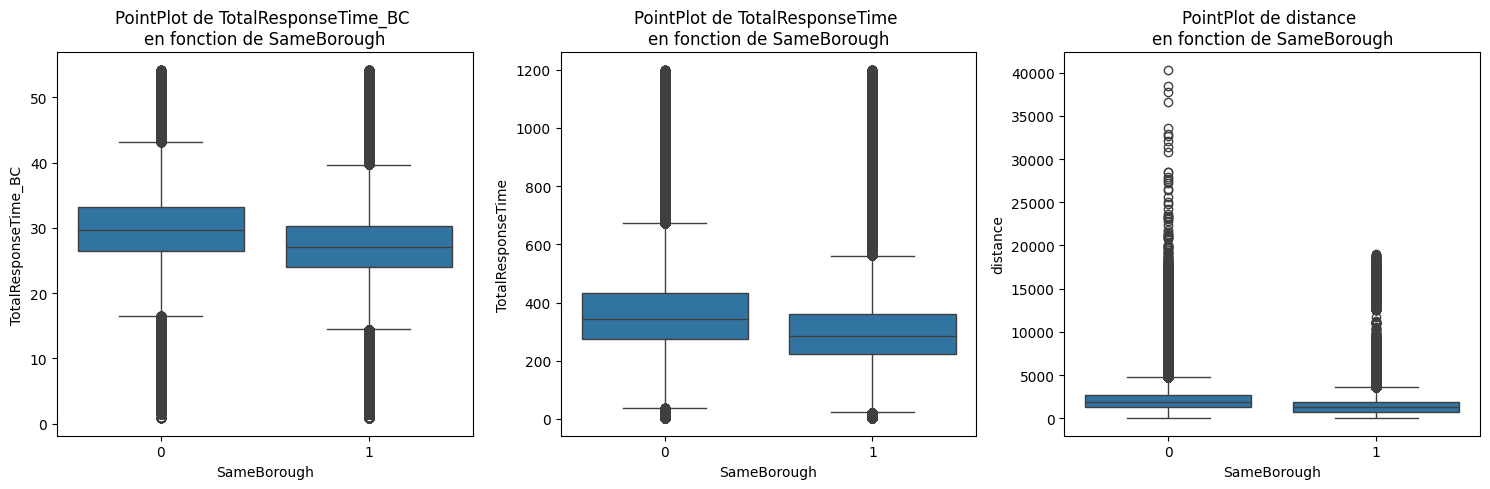

In [ ]:
# au vu du nombre de catégories, on représente les graphiques avec un catplot
nom_png='/content/gdrive/My Drive/1_Rendu/20241115/IMG/000_delete.png'
graphQuali_boxplot(df_merge,'SameBorough', nom_png)

In [ ]:
display(df_merge.loc[df_merge.SameBorough==0, ['TotalResponseTime_BC', 'TotalResponseTime', 'distance']].describe())
print('\n')
display(df_merge.loc[df_merge.SameBorough==1, ['TotalResponseTime_BC', 'TotalResponseTime', 'distance']].describe())

,TotalResponseTime_BC,TotalResponseTime,distance
count,234024.000000,234024.00000,234024.000000
mean,30.032797,368.29444,2356.866387
std,5.690068,143.39255,1965.870970
min,0.816058,2.00000,3.272000
25%,26.505043,275.00000,1353.590500
50%,29.608370,344.00000,1939.488000
75%,33.185632,434.00000,2728.140000
max,54.217048,1200.00000,40325.334000


,TotalResponseTime_BC,TotalResponseTime,distance
count,803689.000000,803689.000000,803689.000000
mean,27.228800,303.448059,1578.450238
std,5.513804,124.596107,1664.141915
min,0.816058,2.000000,0.204000
25%,23.928291,224.000000,781.208000
50%,27.025952,286.000000,1288.260000
75%,30.237062,359.000000,1928.185000
max,54.217048,1200.000000,18956.997000
